In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
import gpflow
from utils import *

2025-02-08 02:43:28.278448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739007808.297262   12147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739007808.303314   12147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 02:43:28.325733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data

In [2]:
train_files= ['ssp126', 'ssp585', 'historical']

In [3]:
NEOFS = 5 # for testing

In [4]:
Xtrain, eof_solvers, mean, std = get_Xtrain(train_files, NEOFS)

In [5]:
Ytrain = get_Ytrain(train_files)

In [6]:
Ytrain_yield = Ytrain['mai'].values.reshape(-1, 360*720)

In [7]:
Xtest = get_Xtest('ssp370', eof_solvers, mean, std)

In [8]:
Ytest = get_Ytest('ssp370')

In [9]:
yield_truth = Ytest['mai']

In [10]:
# NEOFS = 5 # for testing

# Xtrain, eof_solvers, mean, std = get_Xtrain(train_files, NEOFS)

# Ytrain = get_Ytrain(train_files)
# Ytrain_yield = Ytrain['mai'].values.reshape(-1, 360*720)

# Xtest = get_Xtest('ssp370', eof_solvers, mean, std)

# Ytest = get_Ytest('ssp370')
# yield_truth = Ytest['mai']

In [11]:
Xtrain

,pr_0,pr_1,pr_2,pr_3,pr_4,rlds_0,rlds_1,rlds_2,rlds_3,rlds_4,...,tasmax_0,tasmax_1,tasmax_2,tasmax_3,tasmax_4,tasmin_0,tasmin_1,tasmin_2,tasmin_3,tasmin_4
time,,,,,,,,,,,,,,,,,,,,,
0,-0.108815,-0.392872,-1.742120,0.594152,-1.060625,-0.054500,-0.549874,0.040439,-0.701462,0.976584,...,-0.125127,-0.828057,0.201142,-0.406998,0.899865,-0.091674,-0.724240,-0.045461,0.372588,-1.346447
1,0.227408,-0.853807,0.746168,-0.178718,-0.949510,-0.044635,0.268816,-0.609286,0.541444,0.280499,...,-0.112254,0.225410,0.727773,-1.598736,0.423742,-0.080990,0.258557,-0.690854,1.537931,-0.871188
2,0.185860,1.807987,1.262223,0.705759,-0.647298,-0.071871,-0.838767,2.188947,0.439997,-1.071673,...,-0.143468,-1.156418,-1.281710,-1.430485,1.126653,-0.131173,-1.184524,1.473706,1.294528,-0.772252
3,0.169923,0.784532,-1.418563,-0.235135,0.172562,-0.011602,-1.009635,0.646478,-1.502691,0.402829,...,-0.091626,-1.006087,-0.135322,-0.604755,1.045547,-0.055598,-0.998433,0.306421,0.169490,-1.672239
4,0.240338,-1.719567,0.522800,-0.975495,0.368070,0.086567,-0.297138,-1.921774,-0.903525,-0.798596,...,0.043245,-0.025916,2.100326,0.004125,1.709191,0.072500,0.028049,-2.021463,-0.680830,-1.782924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0.640577,0.765282,1.410714,-0.193006,-0.867874,-0.383357,-0.430657,0.605216,1.991673,-0.058020,...,-0.459388,-0.116410,-0.030071,-1.242890,-1.630163,-0.441553,-0.347630,-0.121953,1.526366,1.352686
333,0.456759,1.838081,0.165938,0.178778,-0.719262,-0.308276,-0.317059,1.821296,0.407511,0.520522,...,-0.390612,-0.424142,-1.046824,-1.989826,-0.447917,-0.367688,-0.431276,1.020936,2.073574,-0.167054
334,0.420952,-0.467498,-1.043702,-0.357060,0.498970,-0.217537,0.048349,-0.944545,-0.764564,-0.009817,...,-0.312549,-0.227497,0.710704,-0.839396,1.193251,-0.281706,-0.167312,-0.643699,0.416816,-1.369983


In [12]:
Xtrain.to_csv('Xtrain.csv')

In [13]:
Xtest

,pr_0,pr_1,pr_2,pr_3,pr_4,rlds_0,rlds_1,rlds_2,rlds_3,rlds_4,...,tasmax_0,tasmax_1,tasmax_2,tasmax_3,tasmax_4,tasmin_0,tasmin_1,tasmin_2,tasmin_3,tasmin_4
time,,,,,,,,,,,,,,,,,,,,,
2015,0.193427,0.661676,-0.525480,-0.016522,0.027948,-0.180173,-0.666578,0.192553,0.946834,-0.408361,...,-0.224849,-0.719204,-0.242755,-0.269233,-0.458377,-0.205389,-0.860739,0.153464,0.408287,0.558258
2016,0.193925,0.105958,-0.928623,0.191408,0.764877,-0.078665,-0.105659,-0.167268,-0.350459,0.453205,...,-0.163296,-0.475882,0.184280,-0.672782,-0.120488,-0.132481,-0.528858,-0.219960,0.495307,-0.593879
2017,0.238566,-1.013872,-0.616513,-0.298991,-0.894010,0.001682,-0.206976,-0.641434,-0.582640,0.426865,...,-0.023143,-0.016441,1.254611,-0.182194,0.693137,0.011193,-0.091520,-1.063469,-0.018543,-0.962883
2018,0.200564,-1.052187,0.366829,0.160156,-0.282438,0.031402,0.172573,-0.557223,1.109690,0.414260,...,-0.026970,0.287339,1.056607,-1.314239,-0.544706,-0.005862,0.089489,-0.953150,1.214397,0.277776
2019,0.225334,-0.146257,-0.121523,0.012748,-0.411779,0.026164,-0.184394,-0.211381,0.438147,-0.586573,...,-0.034665,-0.170651,0.423687,-1.096396,0.174191,0.000003,-0.219289,-0.434109,1.026853,-0.053915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,-2.275170,0.124475,-1.261006,0.888496,-1.529115,1.993063,-0.172647,0.329155,0.417775,1.690943,...,1.977600,0.403393,-0.466720,1.554377,-1.857734,1.975893,0.366533,0.553481,-1.303596,1.889834
2097,-2.032794,-0.120490,1.846045,0.477208,-0.046837,2.067830,1.714509,0.452533,1.969580,1.004514,...,2.029340,1.772185,-0.485322,-1.637476,-1.584829,2.032629,1.640131,0.245828,1.857394,1.523149
2098,-1.724539,2.457613,-0.804473,1.059008,-0.865256,1.904483,-0.634920,1.655779,0.680090,2.363433,...,1.881240,-0.263602,-1.698997,0.102594,-2.089599,1.871740,-0.299588,1.483098,0.031173,1.259327


In [14]:
Xtest.to_csv('Xtest.csv')

In [15]:
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_yield = Ytrain_yield[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_yield.shape[0]

In [16]:
test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
yield_truth = yield_truth[~test_nan_mask]

In [17]:
mask_all_nan_by_col = np.isnan(Ytrain_yield).all(axis=0)

In [18]:
np.isnan(Ytrain_yield).sum() - 337*mask_all_nan_by_col.sum()

13205

In [19]:
Ytrain_yield_dropped = Ytrain_yield[:, ~mask_all_nan_by_col]

In [20]:
Y_imputed = np.nan_to_num(Ytrain_yield_dropped, nan=0.0)

In [21]:
# Standardize predictand fields
train_yield_mean, train_yield_std = Y_imputed.mean(), Y_imputed.std()
Y_imputed = (Y_imputed - train_yield_mean) / train_yield_std

## Model

In [22]:
kernel = (
    gpflow.kernels.Matern32(active_dims=[0, 1, 2, 3, 4], lengthscales=[1.0]*5) +  # pr
    gpflow.kernels.Matern32(active_dims=[5, 6, 7, 8, 9], lengthscales=[1.0]*5) +  # rlds
    gpflow.kernels.Matern32(active_dims=[10, 11, 12, 13, 14], lengthscales=[1.0]*5) +  # rsds
    gpflow.kernels.Matern32(active_dims=[15, 16, 17, 18, 19], lengthscales=[1.0]*5) +  # sfcwind
    gpflow.kernels.Matern32(active_dims=[20, 21, 22, 23, 24], lengthscales=[1.0]*5) +  # tas
    gpflow.kernels.Matern32(active_dims=[25, 26, 27, 28, 29], lengthscales=[1.0]*5) +  # tasmax
    gpflow.kernels.Matern32(active_dims=[30, 31, 32, 33, 34], lengthscales=[1.0]*5)    # tasmin
)

I0000 00:00:1739008028.529667   12147 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15452 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:18:00.0, compute capability: 6.0


In [23]:
np.random.seed(5)

mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Y_imputed.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [24]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=5000))

I0000 00:00:1739008034.592707   12617 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x55ec226c8d20


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -25383.66701427137
        x: [ 1.015e+01  1.178e+01 ... -2.886e+00 -5.492e-02]
      nit: 86
      jac: [ 4.364e-17  3.664e-17 ... -4.552e-01 -1.280e+00]
     nfev: 102
     njev: 102
 hess_inv: <44x44 LbfgsInvHessProduct with dtype=float64>

## Prediction

In [25]:
Xtest64 = Xtest.astype(np.float64)

In [26]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest64.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_yield_std + train_yield_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_yield_std # transform variance prediction to original scale standard deviation

In [27]:
posterior_yield_mean_full = np.full((Xtest64.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_mean_full[:, ~mask_all_nan_by_col] = posterior_mean

posterior_yield_stddev_full = np.full((Xtest64.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_stddev_full[:, ~mask_all_nan_by_col] = posterior_stddev

In [28]:
# put output back into xarray format for calculating RMSE/plotting
posterior_yield = np.reshape(posterior_yield_mean_full, [yield_truth.shape[0], 360, 720])
posterior_yield_stddev = np.reshape(posterior_yield_stddev_full, [yield_truth.shape[0], 360, 720])

posterior_yield_data = xr.DataArray(posterior_yield, dims=yield_truth.dims, coords=yield_truth.coords)
posterior_yield_std_data = xr.DataArray(posterior_yield_stddev, dims=yield_truth.dims, coords=yield_truth.coords)

In [29]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(yield_truth[35], posterior_yield_data[35])}")
print(f"RMSE at 2100: {get_rmse(yield_truth[85], posterior_yield_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(yield_truth[30:41], posterior_yield_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(yield_truth[75:], posterior_yield_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(yield_truth[35:], posterior_yield_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(yield_truth[-20:].mean(dim='time'), posterior_yield_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.5705619534404591
RMSE at 2100: 0.5934742037971339
RMSE 2045-2055: 0.5447469099450973
RMSE 2090-2100: 0.5267468667329035
RMSE 2050-2100: 0.5404215484494972
RMSE average last 20y: 0.15415643854451683


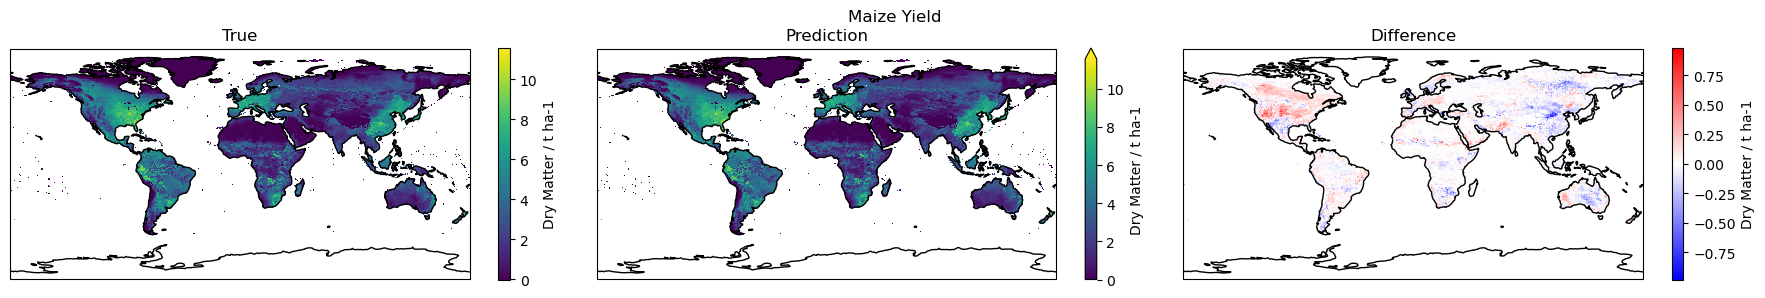

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

truth_mean = yield_truth.sel(time=slice(2050,None)).mean('time')
posterior_mean = posterior_yield_data.sel(time=slice(2050,None)).mean('time')
difference = truth_mean - posterior_mean

tmin, tmax = float(truth_mean.min()), float(truth_mean.max())
pmin, pmax = float(posterior_mean.min()), float(posterior_mean.max())
dmin, dmax = float(difference.min()), float(difference.max())


buffer = 0.001
vmin = tmin - buffer
vmax = tmax + buffer


abs_max_diff = max(abs(dmin), abs(dmax))
diffnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-abs_max_diff, vmax=abs_max_diff)

# Plot
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,3))
fig.suptitle('Maize Yield')

# 1) Truth
ax1 = plt.subplot(131, projection=proj)
truth_mean.plot(
    ax=ax1, cmap="viridis",
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax1.coastlines()
ax1.set_title('True')

# 2) Posterior
ax2 = plt.subplot(132, projection=proj)
posterior_mean.plot(
    ax=ax2, cmap="viridis",
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax2.coastlines()
ax2.set_title('Prediction')

# 3) Difference
ax3 = plt.subplot(133, projection=proj)
difference.plot(
    ax=ax3, cmap="bwr",
    norm=diffnorm,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax3.coastlines()
ax3.set_title('Difference')

plt.tight_layout()
plt.show()


In [31]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.0549241]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9.144392497726337e-22
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[10.15414, 11.77648, 6.24941..."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.254595185056815e-15
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[40.75974, 27.09985, 26.47612..."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.8198839708257332
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[10.73209, 44.56093, 44.10623..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,5.406203355252964e-19
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[16.27294, 14.7666, 14.77244..."
GPR.kernel.kernels[4].variance,Parameter,Softplus,,True,(),float64,6.934858067832296e-17
